# Nuclei Deconvolution and Segmentation

This notebook shows deconvolution and segmentations of an image from the ABRF-LMRG Image Analysis Study.  Details about the study can be found here

https://sites.google.com/view/lmrg-image-analysis-study

Question:  Does deconvolution really make downstream measurements more accurate?  In this example we deconvolve, segment and then compare the segmentation to the ground truth segmentation provided by the study organizers.  We use the [stardist](https://github.com/stardist/stardist) matching utility to score the segmentation against the ground truth segmentation. 

Discovering whether deconvolution improves measurements is tricky, because the optimal segmentaton approach for original and deconvolved image may be different.  Someone segmenting the original may come up with a sophisticated segmentation strategy that compensates for the blur without deconvolution, others may apply deep learning to the problem.  We invite people to score their own solutions.


## Create a decon conda environment

This environment should be the same as in the first example

So first use mamba to create a new environment based on devbio-napari

```
mamba create --name deconvolution-napari-env python=3.9 devbio-napari -c conda-forge -c pytorch
```

Now install cuda and cupy.  

(TODO1: will these be istalled as part of morning session?)
(TODO2: clarify whether cupy can work on Mac and provide alternative for example that uses cupy)

Note: You can probably use a version different than 11, just make sure cudatookkit and cupy versions are compatible.

```
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
pip install cupy-cuda11x
```

Now let's install the tnia-python library (for projections and some helper functions), clij2-fft (for deconvolution), stardist (for measuring segmentation quality and for an example comparing classical deconvolution to deep learning deconvolution) and psfmodels (for diffractions based PSFs). 

```
pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-fft
pip install stardist
pip install psfmodels
```

And for an example showing how to simulate images for deconvolution testing (and deep learning training)

```
pip install raster-geometry
```

Mac-users may also need to install this:

    conda install -c conda-forge ocl_icd_wrapper_apple

Linux users may also need to install this:

    conda install -c conda-forge ocl-icd-system


## Open test images

1.  Get images from this folder https://www.dropbox.com/scl/fo/ngs73x29t1ch8208d75lv/h?rlkey=7acq2epqp1f1x039q833ry6p4&dl=0
2.  In the code snippet below change ```im_path``` to the local location on your machine where you put the above folder
3.  Print out the size of the images to verify they loaded propertly.  Note that the ground truth and image are different sizes, that is something we will have to deal with (with a careful resizing operation) before comparing. 

In [1]:
from skimage.io import imread

im_path='D:/images/dresdengpu2022/deconvolution/'
im_name='nuclei4_out_c90_dr10_image.tif'
truth_name='out_c90_dr10_label.tif'

im=imread(im_path+im_name)
truth=imread(im_path+truth_name)
im=im.astype('float32')
print(im.shape, truth.shape)

(100, 258, 258) (161, 258, 258)


## Resize truth, show image and truth

We need to resize the truth image as it was generated with isotropic voxels.  We have to be careful when resizing a label image as we don't want to interpolate label vales.  Thus the order of the resizing operation needs to be 0 (which means no interpolation will be used).

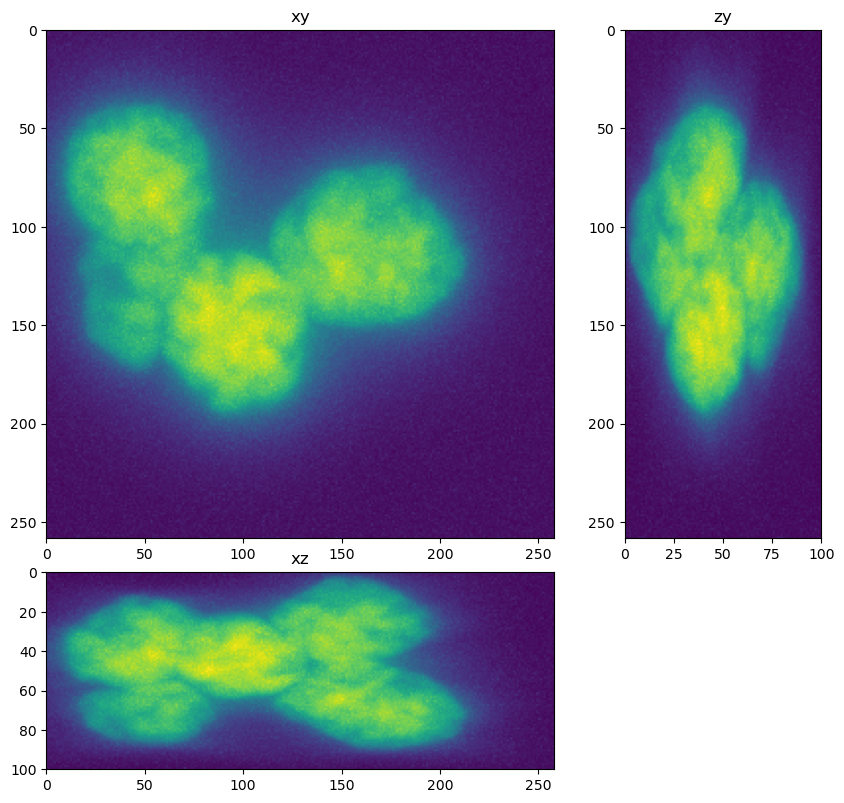

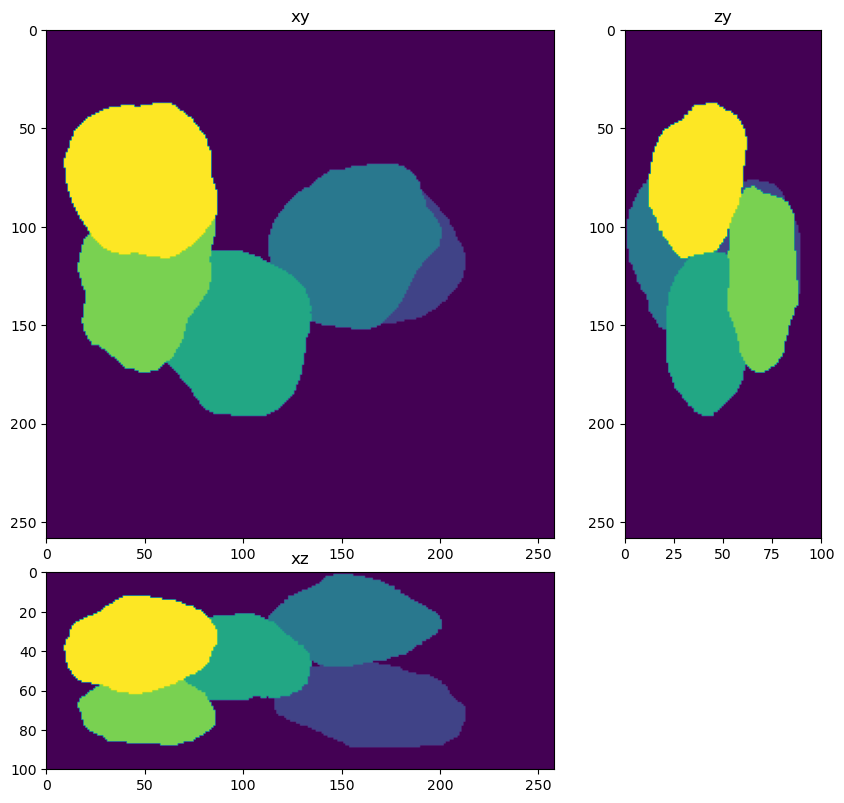

In [2]:
from tnia.plotting.projections import show_xyz_max
from skimage.transform import resize

truth = resize(truth, [im.shape[0],im.shape[1], im.shape[2]], preserve_range=True, order=0, anti_aliasing=False).astype('int32')

fig=show_xyz_max(im)
fig=show_xyz_max(truth)

## Create PSF

The image is a 3D Z-Stack Widefield fluorescence image, so deconvolution should help remove blur, increase contrast and lead to better segmentation and quantification.  One hiccup I had was that the data did not deconvolve well using the meta data provided (20x/0.75NA, Voxel dimensions: 0.124x0.124x0.200 um, Emission peak wavelength: 500 nm).  I followed up with the organizers about this and they discovered there was an error reading meta data from the psf file used in the simulation.  This meant the effective spaces were likely 372 nm in XY and 2800 nm in Z. 

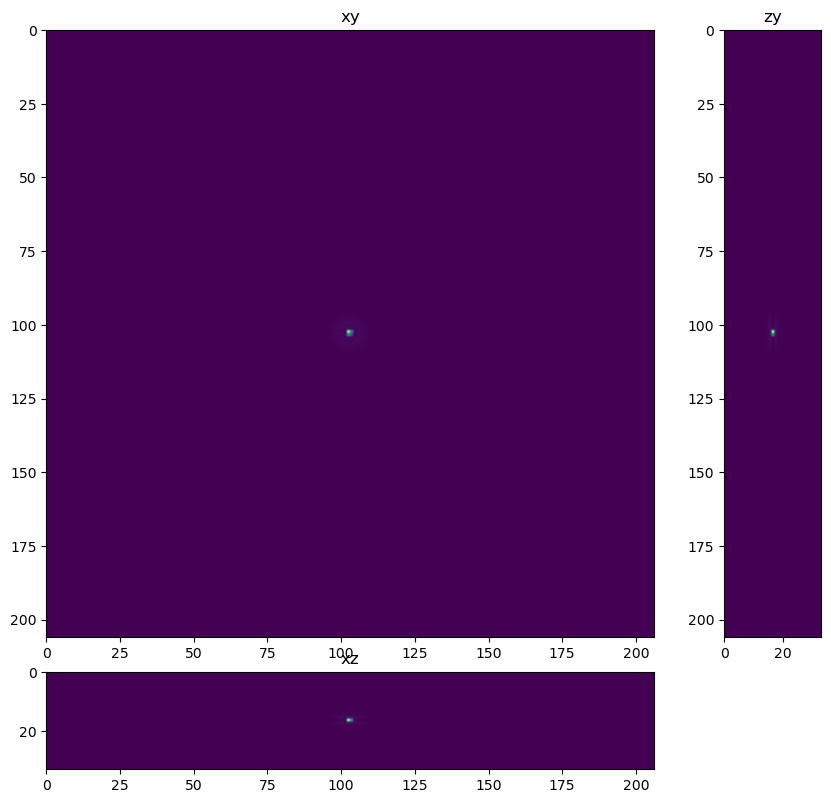

In [6]:
from tnia.deconvolution.psfs import gibson_lanni_3D

x_voxel_size = 0.372
z_voxel_size=2.8
#x_voxel_size = 0.1
#z_voxel_size=.8

xy_psf_dim=206
z_psf_dim=33

NA=0.75
ni=1
ns=1

psf  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim, z_psf_dim, 0, 0.5, False, True)
psf = psf.astype('float32')
fig = show_xyz_max(psf)

## Import Deconvolotion and make a 'deconvolver'



In [7]:
try:
    from clij2fft.richardson_lucy import richardson_lucy_nc
    print('clij2fft non-circulant rl imported')
    regularization_factor=0.0005
    def deconvolver(img, psf, iterations):
        return richardson_lucy_nc(img, psf, iterations, regularization_factor)
    
except ImportError:
    print('clij2fft non-circulant rl not imported')
    try:
        import RedLionfishDeconv as rl
        print('redlionfish rl imported')
        def deconvolver(img, psf, iterations):
            return rl.doRLDeconvolutionFromNpArrays(im, psf, niter=100, method='gpu', resAsUint8=False )
    except ImportError:
        print('redlionfish rl not imported')


clij2fft non-circulant rl imported


get lib


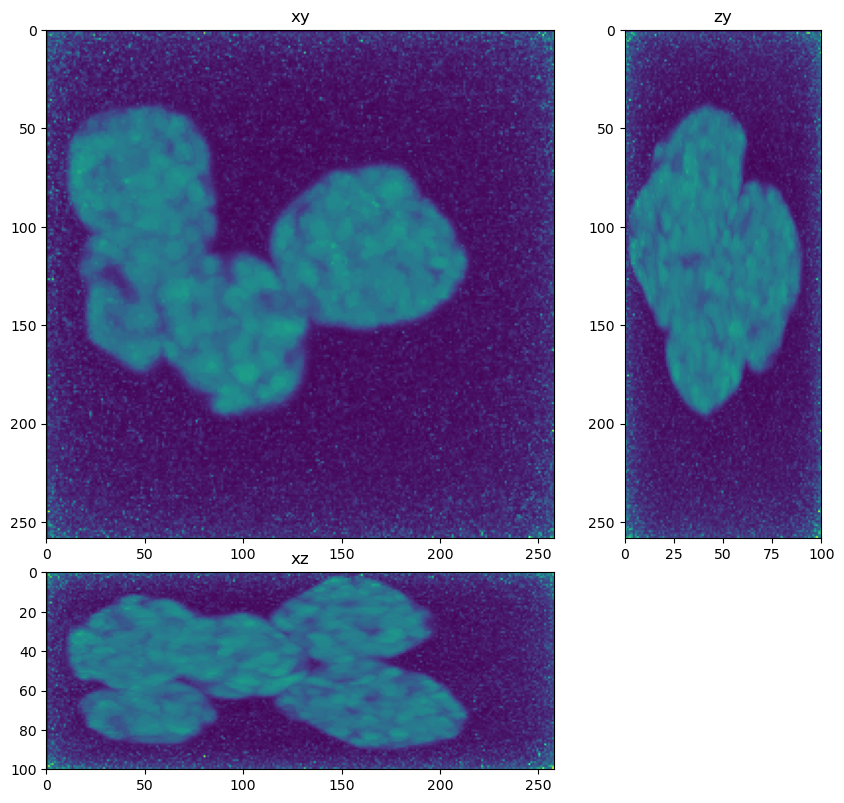

In [8]:
im_decon = deconvolver(im, psf, 200)

fig = show_xyz_max(im_decon)

## Make a Segmenter

This segmenter has been optimized for deconvolved data.  The important steps are

1.  Resize the image to isotropic voxels (this helps the performance of the downstream watershed)
2.  Apply multiple levels of Otsu threshold to detect separate both the bright and dark parts of the nuclei from the background.
3.  After 2 levels of Otsu fill any remaining holes
4.  Call a watershed function passing in a 'spot sigma' and 'distance sigma'.  The spot sigma is used to blur the image before peak detection.  The distance sigma is used to blur the image before calculating a distance map.  Spot sigma is ussually larger than distance sigma.
5.  As a final step, loop through all detected objects and apply binary cleaning (erosion, opening and closing) to each object separately. 

In [9]:
from tnia.morphology.fill_holes import fill_holes_3d_slicer, fill_holes_slicer
from skimage.filters import threshold_otsu
from tnia.morphology.fill_holes import fill_holes_3d_slicer, fill_holes_slicer
from skimage.measure import label
from tnia.segmentation.separate import separate_touching2, separate_touching
import numpy as np
from skimage.morphology import binary_closing, binary_opening, binary_erosion, ball
from skimage.measure import regionprops

sx=0.1238
sy=0.1238 
sz=0.2

def segmenter(im):
    
    # resize to isotropic voxels (watershed tends to work better with isotropic voxels)
    resized= resize(im, [int(sz*im.shape[0]/sx),im.shape[1], im.shape[2]])
    
    # apply 2 levels of Otsu threshold
    # first apply Otsu threshold to entire image
    binary = resized>threshold_otsu(resized)
    # now apply Otsu threshold to the background from 1st Otsu application
    # (the nuclei have dark regions for which a second application of Otsu is needed)
    binary = resized>threshold_otsu(resized[binary==0])
    
    # fill any remaining holes 
    fill_holes_slicer(binary,1000)
    
    # now call a customized watershed to seperate objects
    labels, _, = separate_touching2(binary, binary, 5, [15,15,15],[5,5,5])
    
    # resize back to original
    labels = resize(labels, [im.shape[0],im.shape[1], im.shape[2]], preserve_range=True, order=0, anti_aliasing=False).astype('int32')
    
    # get the regions
    object_list=regionprops(labels,im)
    labels2=np.zeros_like(labels)

    i=1
    r=7
    
    # here we loop through each object detected applying opening and closing to them separately to 
    # clean noise from the surface and fill gaps in the surface
    for obj in object_list:
        z1,y1,x1,z2,y2,x2=obj.bbox
        temp=np.pad(obj.image,r)
        temp=binary_erosion(temp, ball(1))
        temp=binary_opening(temp, ball(r))
        temp=binary_closing(temp, ball(r))
        temp=temp[r:-r,r:-r,r:-r]
        labels2[z1:z2,y1:y2,x1:x2][temp==True]=i
        i=i+1
        
    return labels2

## Apply the segmenter to the deconolved data

(5, 3)


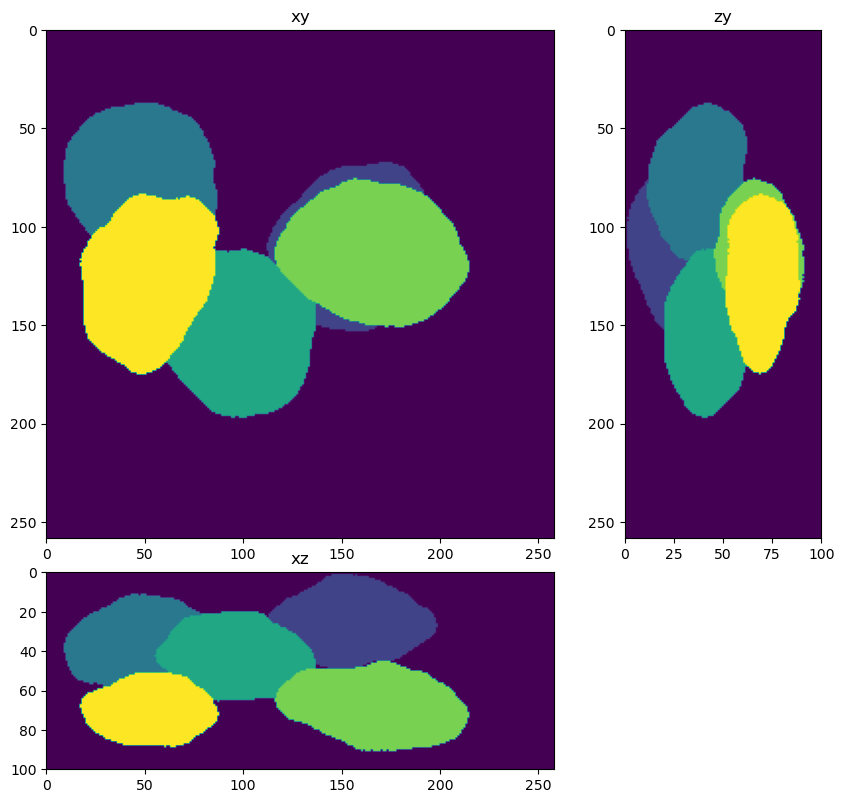

In [10]:
from skimage.measure import label

labels=segmenter(im_decon)

fig = show_xyz_max(labels)

## Score the solution using the stardist matcher

In [12]:
from stardist.matching import matching

matching(truth, labels)

Matching(criterion='iou', thresh=0.5, fp=0, tp=5, fn=0, precision=1.0, recall=1.0, accuracy=1.0, f1=1.0, n_true=5, n_pred=5, mean_true_score=0.9111668586730957, mean_matched_score=0.9111668586730957, panoptic_quality=0.9111668586730957)

## Visualize in Napari

In [13]:
# relabel before visualization to make sure the same label indexes are used
truth=label(truth)
labels=label(labels)


import napari
viewer=napari.Viewer()

viewer.add_image(im)
viewer.add_image(im_decon)
viewer.add_labels(truth)
viewer.add_labels(labels)


<Labels layer 'labels' at 0x1b9d71ad9a0>